In [1]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\seema\appdata\local\programs\python\python37-32\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Dataset Preparation

In [2]:
p = Path("images")
dirs = p.glob("*")

labels_dict = {"cat":0 , "dog":1 , "horse":2 , "human":3}
img_data = []
labels = []
for folder_name in dirs:
#     print(folder_name)
    label  = str(folder_name).split("\\")[-1][:-1]
    print(label)

    for img_path in folder_name.glob('*.jpg'):
        img = image.load_img(img_path , target_size=(32,32))
        img_arr = image.img_to_array(img)  # totalimg*100*100*3
        img_data.append(img_arr)
        labels.append(labels_dict[label])

cat
dog
horse
human


In [3]:
img_data = np.array(img_data,dtype='float32')/255.0
labels = np.array(labels)

print(img_data.shape)
print(labels.shape)

(808, 32, 32, 3)
(808,)


### Shuffling

In [4]:
import random

combined = list(zip(img_data,labels))

random.shuffle(combined)

img_data[:],labels[:] =zip(*combined)

### Visualise Data

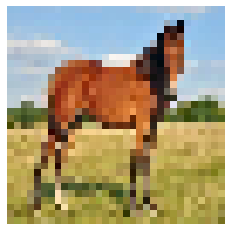

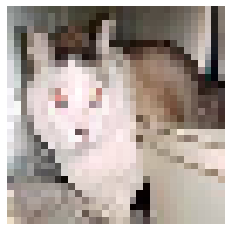

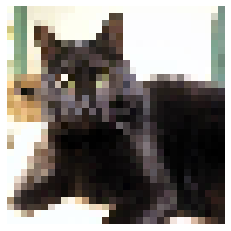

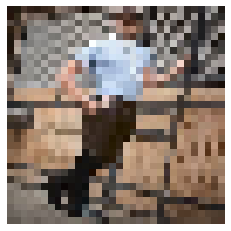

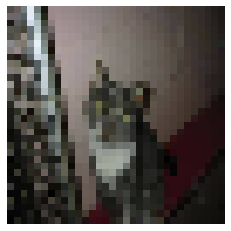

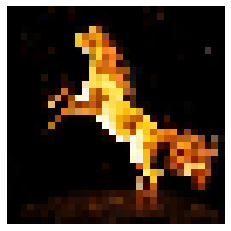

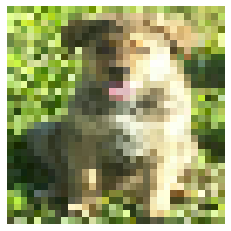

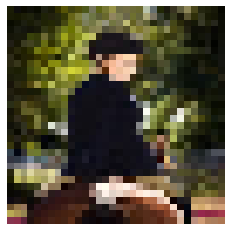

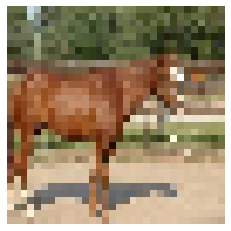

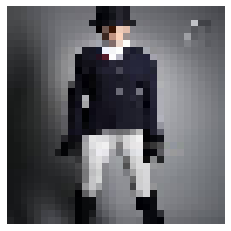

In [5]:
def drawimg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
for i in range(10):
    drawimg(img_data[i])

## SVM Classifier

In [6]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeloss(self,W,b,X,Y):         # Loss Function
        loss = 0.0
        
        loss += 0.5*np.dot(W,W.T)
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C*(max(0,(1-ti)))
            
        return loss[0][0]          #because loss is a matrix
    
    def fit(self,X,Y,maxItr=1000,batch_size=100,learning_rate=0.00001):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        n = learning_rate
        c = self.C
         
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        b = 0.0
        
        #Initial Loss
        print(self.hingeloss(W,b,X,Y))
        
        #Training from here....
        losses = []
        
        for i in range(maxItr):
            
            l = self.hingeloss(W,b,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0,no_of_samples,batch_size):
                # Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_size+batch_start):
                    if j<no_of_samples:   #for not accessing out of limitd
                        i = ids[j]
                        ti = Y[i]*(np.dot(W,X[i].T)+b)
                        
                        if ti>1:
                            gradb+=0
                            gradw+=0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready!! 
                W = W - n*W + n*gradw
                b = b + n*gradb
             
        self.W = W
        self.b = b
        return W,b,losses
                    
        

### Converting data for OneVsOne

In [7]:
M = img_data.shape[0]
img_data = img_data.reshape(M,-1)
print(img_data.shape)

(808, 3072)


In [8]:
CLASSES = len(np.unique(labels))

In [9]:
def classWiseData(x,y):
    
    data = {}
    
    for i in range(CLASSES):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [10]:
data = classWiseData(img_data,labels)

In [11]:
def getDataPairForSVM(d1,d2):
    
    # Combines data of two classes into a single matrix
    
    
    l1,l2 = d1.shape[0],d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair,data_labels

### Training nC2 classifiers

In [12]:
mySVM = SVM()

In [13]:
def trainSVM(x,y):
    
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,bias,loss = mySVM.fit(xpair,ypair)
            svm_classifiers[i][j] = (wts,bias)
            
    return svm_classifiers

In [14]:
svm_classifiers = trainSVM(img_data,labels)

404.0
404.0
404.0
404.0
404.0
404.0


### Prediction

In [15]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [16]:
def predict(x):
    
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svm_classifiers[i][j]
            # Take majority prediction
            z = binaryPredict(x,w,b)
            if z == 1:
                count[j] += 1
            else:
                count[i] += 1
                
    return np.argmax(count)

In [17]:
print(predict(img_data[2]))
print(labels[2])

0
0


In [18]:
def accuracy(x,y):
    
    count = 0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction == y[i]):
            count += 1
            
    return count/x.shape[0]

In [19]:
accuracy(img_data,labels)

0.6076732673267327